In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report
from scipy.optimize import linprog


class RationalClassifier:
    def __init__(self, numerator_degree, denominator_degree, n_components, delta=1e-5, precision=1e-6):
        self.numerator_degree = numerator_degree
        self.denominator_degree = denominator_degree
        self.n_components = n_components
        self.delta = delta
        self.precision = precision
        self.alpha = None
        self.beta = None
        self.z = None

    def fit(self, X, y):
        """
        Train the rational classifier by solving for optimal alpha, beta, and z.
        """
        # Convert y to a NumPy array
        y = np.asarray(y)

        # Generate rational function matrices
        G_matrix, H_matrix = generate_rational_function_matrix(
            self.numerator_degree, self.denominator_degree, self.n_components, X
        )

        # Use bisection method to find optimal z
        self.z = bisection_method(
            uL=0, uH=1000, G_matrix=G_matrix, H_matrix=H_matrix, y=y, precision=self.precision
        )

        # Solve for alpha and beta at the optimal z
        result = solve_lp(self.z, G_matrix, H_matrix, y, delta=self.delta)
        if not result.success:
            raise ValueError("Linear programming failed to converge.")

        # Extract alpha and beta coefficients
        self.alpha = result.x[1: 1 + G_matrix.shape[1]]
        self.beta = result.x[1 + G_matrix.shape[1]:]

    def predict(self, X):
        """
        Predict class labels for input data X.
        """
        # Generate rational function matrices for prediction
        G_matrix, H_matrix = generate_rational_function_matrix(
            self.numerator_degree, self.denominator_degree, self.n_components, X
        )

        # Compute rational function values
        numerator = np.dot(G_matrix, self.alpha)
        denominator = 1e-5 + np.dot(H_matrix, self.beta)
        rational_values = numerator / denominator

        # Apply threshold to classify
        predictions = (rational_values > 0.3).astype(int)
        return predictions


# Helper functions
def r_multi_indices(n, d):
    if n == 1:
        yield (d,)
    else:
        for k in range(d + 1):
            for c in r_multi_indices(n - 1, k):
                yield (d - k, *c)


def generate_multi_indices(n, d):
    from itertools import chain
    return list(chain(*[list(r_multi_indices(n, _)) for _ in range(d + 1)]))


def generate_rational_function_matrix(numerator_degree, denominator_degree, n_components, dataset):
    G_indices = generate_multi_indices(n_components, numerator_degree)
    H_indices = generate_multi_indices(n_components, denominator_degree)

    G_matrix = np.zeros((len(dataset), len(G_indices)))
    H_matrix = np.zeros((len(dataset), len(H_indices)))

    for i, data_point in enumerate(dataset):
        G_matrix[i] = [np.prod([data_point[k] ** idx[k] for k in range(len(data_point))]) for idx in G_indices]
        H_matrix[i] = [np.prod([data_point[k] ** idx[k] for k in range(len(data_point))]) for idx in H_indices]

    return G_matrix, H_matrix


def solve_lp(z, G_matrix, H_matrix, y, delta=1e-5):
    y = np.asarray(y)  # Ensure y is a NumPy array
    length_dataset = len(y)
    num_alpha = G_matrix.shape[1]
    num_beta = H_matrix.shape[1]

    c = [1] + [0] * (num_alpha + num_beta)
    A_ub, b_ub = [], []

    for i in range(length_dataset):
        G_row = G_matrix[i]
        H_row = H_matrix[i]
        y_i = y[i]

        # First constraint
        A_ub.append([-1] + [-g for g in G_row] + [(y_i - z) * h for h in H_row])
        b_ub.append(0)

        # Second constraint
        A_ub.append([-1] + [g for g in G_row] + [-(y_i - z) * h for h in H_row])
        b_ub.append(0)

        # Positivity constraint
        A_ub.append([0] + [0] * num_alpha + [-h for h in H_row])
        b_ub.append(-delta)

    bounds = [(0, None)] + [(None, None)] * (num_alpha + num_beta)
    result = linprog(c=c, A_ub=np.array(A_ub), b_ub=np.array(b_ub), bounds=bounds, method="highs")
    return result


def bisection_method(uL, uH, G_matrix, H_matrix, y, precision=1e-6):
    y = np.asarray(y)  # Ensure y is a NumPy array

    while (uH - uL) > precision:
        z = (uH + uL) / 2
        result = solve_lp(z, G_matrix, H_matrix, y)

        if result.success:
            uH = z
        else:
            uL = z

    return uH


# Main script
# Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X = mnist.data
y = mnist.target.astype(int)

# Randomly select 500 samples from the dataset
subset_size = 1000
indices = np.random.choice(len(X), subset_size, replace=False)
X_subset = X.iloc[indices]  # Use .iloc for row selection
y_subset = y.iloc[indices]


#change the class here
# Binarize the labels (e.g., digit 0 vs. not 0 for binary classification)
y_binary_subset = (y_subset == 6).astype(int)

# Normalize the features
scaler = MinMaxScaler()
X_subset_scaled = scaler.fit_transform(X_subset)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_subset_scaled, y_binary_subset, test_size=0.2, random_state=42
)

# Apply PCA for dimensionality reduction
n_components = 10
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
# Flattened original test images
original_images = X_test
# Initialize and train the RationalClassifier
numerator_degree = 2
denominator_degree = 2
classifier = RationalClassifier(numerator_degree, denominator_degree, n_components)
classifier.fit(X_train_pca, y_train)

# Evaluate the model
y_pred = classifier.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))


Accuracy: 0.97
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       181
           1       0.88      0.79      0.83        19

    accuracy                           0.97       200
   macro avg       0.93      0.89      0.91       200
weighted avg       0.97      0.97      0.97       200



In [2]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_correct_predictions(model, X_test, y_test, original_images, title="Correct Predictions Visualization"):
    """
    Visualize only the correctly predicted samples.

    Parameters:
    - model: Trained RationalClassifier instance.
    - X_test: Transformed test dataset (e.g., PCA-transformed test data).
    - y_test: True binary labels of the test dataset.
    - original_images: Original test images (flattened) for visualization.
    - title: Title of the visualization plot.
    """
    # Convert y_test to a numpy array if it's a pandas Series
    y_test = np.array(y_test)

    # Generate predictions
    predictions = model.predict(X_test)

    # Find indices where predictions are correct
    correct_indices = np.where(predictions == y_test)[0]

    if len(correct_indices) == 0:
        print("No correct predictions found.")
        return

    # Number of rows and columns for the grid
    rows = int(np.ceil(len(correct_indices) / 5))  # 5 images per row
    cols = 5

    # Create a figure
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    fig.suptitle(title, fontsize=16, weight='bold')

    # Flatten axes array for easier iteration
    axes = axes.flatten()

    # Iterate through correct predictions
    for idx, ax in zip(correct_indices, axes):
        # Reshape the flattened image back to its original shape (28x28)
        image = original_images[idx].reshape(28, 28)
        true_digit = y_test[idx]
        predicted_digit = predictions[idx]  # The predicted label

        # Plot the image
        ax.imshow(image, cmap='gray')  # Use 'gray' colormap for MNIST
        ax.set_title(f"Pred: {predicted_digit}, True: {true_digit}")  # Show both predicted and true labels
        ax.axis("off")  # Hide axes for cleaner visuals

    # Turn off unused subplots
    for ax in axes[len(correct_indices):]:
        ax.axis("off")

    # Adjust layout and show the plot
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the title
    plt.show()


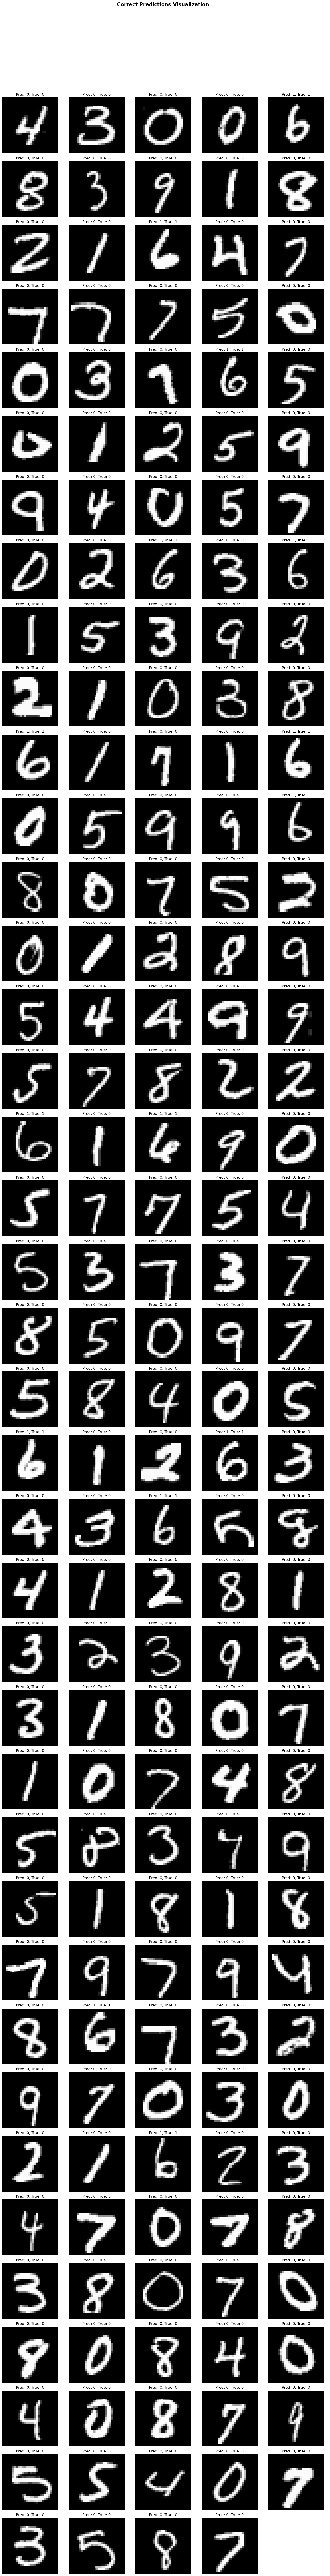

In [3]:
visualize_correct_predictions(
    model=classifier,  # Your trained RationalClassifier instance
    X_test=X_test_pca,  # PCA-transformed test dataset
    y_test=y_test,      # True labels
    original_images=original_images,  # Original flattened test images
    title="Correct Predictions Visualization" 
)
